<img src="https://user-images.githubusercontent.com/23629340/40541063-a07a0a8a-601a-11e8-91b5-2f13e4e6b441.png" alt="logo_ironhack_blue 7" width="100" height="100">

# Ironhack Mid-Bootcamp Project

## Project Overview

Electric Vehicles (EVs) have been around for a couple decades, but its adoption has really picked up in the last 3 years. In this project we will analyze the increasing demand of EVs and who's leading it, figure out in which stage of adoption we are (according to Everett M. Rogger's [*Diffusion of Innovation Theory*](https://en.wikipedia.org/wiki/Diffusion_of_innovations)) and try to estimate how long will it take for the all car transportation to become electric by finding the EV adoption curve.

According to Rogers, when analyzing the adoption of an innovation, the population penetration follows a **normal distribution**, therefore the market share curve will follow its **cumulative distribution function**.
<div align="center">
<img src="http://steveboese.squarespace.com/storage/adoption_of_tech_no_title.jpg?__SQUARESPACE_CACHEVERSION=1450230149150" alt="Adoption curve examples" width="500">
<img src="https://i0.wp.com/ondigitalmarketing.com/wp-content/uploads/2012/01/640px-Diffusionofideas.png?ssl=1" alt="Adoption curve" width="500">
</div>



## Objective
The objective if this project is to answer the following questions:
1. What trend (linear, cuadratic, exponential...) is EV adoption currently following?
2. What is the current stage of Electric Vehicle (EV) adoption? Are we in the phase of Innovators, Early adopters, Early majority, Late majority, or Laggards?
4. Which countries are leading the adoption of EVs? And lagging in the adoption?
5. Which countries are adopting EV's faster (rate of adoption)?
6. How long will full EV adoption take?

Extra:
1. Which companies are leading the transition from ICE (Internal Combustion Engine) vehicles to EVs?
2. Compare the adoption of electric cars to other vehicles (trucks, vans and buses)

### Finding the EV adoption curve:
+ Assuming our datapoints follow a normal distribution, our sales share data points correspond to x values in the Cumulative Distribution Function:
    + $CDF = \Phi(x) = 0.5 * [1 + \frac{erf((x - \mu)}{(\sigma * \sqrt{2}))}]$ where μ is the mean, σ is the standard deviation, and erf() is the error function. We want to find μ and σ so that this equation holds for all of our points. This leads to a system of n nonlinear equations.
    + Using scipy's least squares solver we will solve μ & σ for the given dataset. With this curve we will be able to predict the rate of adoption of EVs worldwide.

## Datasets

+ 2010-2022 Global data on EV sales -> [Global EV Data Explorer](https://www.iea.org/data-and-statistics/data-tools/global-ev-data-explorer)
+ 2010-2022 Global data on car sales -> [Global Passenger Car Sales](https://www.iea.org/data-and-statistics/charts/passenger-car-sales-2010-2022)
+ Historical data on company sales and sales share:
    + [Best Selling Cars](https://www.best-selling-cars.com/brands/2021-full-year-global-volkswagen-brand-worldwide-car-sales-by-model-and-country/)
    + [Toyota](https://global.toyota/en/newsroom/corporate/20966057.html)
    + [EV Adoption](https://evadoption.com/ev-sales/evs-percent-of-vehicle-sales-by-brand/)

# 1 Load libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy import special
from scipy.optimize import least_squares

pio.renderers.default = 'iframe' # set iframe renderer to render plotly charts

# 2 Data Cleaning

## 2.1 Load & Save Raw Data

In [2]:
# Global car sales extracted manually from Internation Energy Agency (IEA) website
car_sales = {'year':[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
             'value': [66700000,71200000,73800000,77500000,80000000,81800000,86400000,86300000,85600000,81300000,71800000,74900000,74800000]}

# Convert dictionary into Pandas Dataframe
car_sales_df = pd.DataFrame(car_sales)

# Save raw data as .csv
car_sales_df.to_csv('../data/raw_data/car_sales_raw.csv',index = False, sep=",")

# Show data
car_sales_df.head()

,year,value
0,2010,66700000
1,2011,71200000
2,2012,73800000
3,2013,77500000
4,2014,80000000


In [3]:
# IEA Global EV Data Explorer API url
api_url = 'https://api.iea.org/evs/?parameter=EV%20sales&mode=Cars&category=Historical&csv=true'

# Download data from IEA website
ev_sales_df = pd.read_csv(api_url)

# Save raw data as .csv
ev_sales_df.to_csv('../data/raw_data/ev_sales_raw.csv',index = False, sep=",")

# Show data & shape
display(ev_sales_df.head())
display(ev_sales_df.shape)

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49
1,Australia,Historical,EV sales,Cars,BEV,2012,Vehicles,170
2,Australia,Historical,EV sales,Cars,PHEV,2012,Vehicles,80
3,Australia,Historical,EV sales,Cars,PHEV,2013,Vehicles,100
4,Australia,Historical,EV sales,Cars,BEV,2013,Vehicles,190


(834, 8)

## 2.2 Explore Data
In this initial data exploration we will explore the ev_sales dataset:
+ study which columns will be useful
+ check for any missing data points
  
car_sales has been extracted manually. There is one value for each year and no missing year values.

In [4]:
# Show values por each column of ev_sales_df
for column in ev_sales_df.columns:
    display(ev_sales_df[column].value_counts())

region
World                26
Belgium              26
United Kingdom       26
China                26
EU27                 26
Europe               26
Germany              25
USA                  25
Spain                25
Poland               25
New Zealand          25
Netherlands          25
Japan                25
France               25
Norway               24
Canada               24
Switzerland          24
Sweden               24
Denmark              24
Other Europe         23
Rest of the world    23
Portugal             23
Australia            23
Finland              23
Italy                23
Israel               23
Iceland              22
Korea                21
Chile                21
Brazil               21
Mexico               20
Turkiye              20
South Africa         19
Austria              18
Greece               18
India                17
Name: count, dtype: int64

category
Historical    834
Name: count, dtype: int64

parameter
EV sales    834
Name: count, dtype: int64

mode
Cars    834
Name: count, dtype: int64

powertrain
BEV     443
PHEV    391
Name: count, dtype: int64

year
2019    72
2020    72
2021    72
2022    72
2015    71
2016    71
2017    71
2018    71
2014    66
2013    63
2012    59
2011    46
2010    28
Name: count, dtype: int64

unit
Vehicles    834
Name: count, dtype: int64

value
1200       12
16000      11
15000      11
11000      10
1500       10
           ..
88000       1
870000      1
510000      1
540000      1
2900000     1
Name: count, Length: 328, dtype: int64

+ In the initial data overview we have found that:
    + 'powertrain' divides ev_sales into PHEV (Plug-in Hybrid Vehicles) and BEV (Battery Electric Vehicles). Since we are only interested in BEV, we will **filter PHEV rows out** and **drop 'powertrain'** column
    + **'category', 'parameter', 'mode', and 'unit'** columns only have 1 possible value. Therefore those columns will be **dropped**.

    + 'region' and 'year' have different number of rows. This indicates we have some missing data. This can be due to:
        + years with 0 sales are excluded (year starts when there are sales), which is in agreement with the 'value' range seen
        + there are missing values for some years


## 2.3 Filter & Clean Data
+ We will **apply the actions in bold stated in the section above** and continue to study the years for each region to decide on next actions.

In [5]:
# Create a dataframe copy to work this section
ev_sales_df1 = ev_sales_df.copy()

# Filter BEV to discard PHEV
ev_sales_df1 = ev_sales_df1[ev_sales_df1['powertrain'] == 'BEV']

# Drop all columns with only 1 value
ev_sales_df1.drop(['category','parameter','mode','powertrain','unit'], axis=1, inplace=True)

# Check top 5 rows
display(ev_sales_df1.head())

,region,year,value
0,Australia,2011,49
1,Australia,2012,170
4,Australia,2013,190
5,Australia,2014,370
8,Australia,2015,760


In the *.value_counts()* above we have seen that there are no 0's in the 'value' column. This suggests that the missing years are the ones where there where no sales. Furthermore, the *.value_counts()* for the years agrees with this statement: earlier years have less values than the most recent ones. However, this doesn't 100% confirm there are no missing rows (years) for all countries. To confirm this, we will have to **check year continuity from the last year (2022) back**.

In [6]:
# Create a function that check for continuity in the years for each region
def check_continuity(df):
    df = df.sort_values(['region', 'year']) # sort values by region and year to ensure chronological order
    missing = []
    for region, group in df.groupby('region'): # iterate df by region groups
        diffs = group['year'].diff() # calculate 
        if not diffs.isin([1, None]).all():  # if there's a difference greater than 1 year
            years = group['year'][diffs > 1]
            for year in years:
                missing.append((region, year - 1))  # previous year is missing
    return missing

In [7]:
# Apply check_continuity function
check_continuity(ev_sales_df1)

[('Turkiye', 2013)]

The only missing value appears to be for region Turkiye, year 2013.

In [8]:
# Check Turkiye's missing value group
ev_sales_df1[ev_sales_df1['region'] == 'Turkiye']

,region,year,value
737,Turkiye,2012,92
740,Turkiye,2014,46
741,Turkiye,2015,120
744,Turkiye,2016,44
745,Turkiye,2017,77
748,Turkiye,2018,190
749,Turkiye,2019,230
752,Turkiye,2020,890
754,Turkiye,2021,3000
755,Turkiye,2022,7000


Sales around year 2013 in Turkiye were really low. In 2012, 92 cars were sold and in 2014, 46 cars were sold. Therefore we conclude the actual sales in Turkiye for the year 2013 were actually 0 - there are no missing values.

In [9]:
# Sort by region and year to ensure chronological order and reset index of dataframe
ev_sales_df1 = ev_sales_df1.sort_values(['region', 'year']).reset_index(drop=True)

## 2.4 Merge Datasets
+ We will now  combine the two datasets: **car_sales_df** and **ev_sales_df1**. To do this we will:
+ **Rename** the column **'value'** in the ev_sales_df to **'ev_sales'**
+ **Add a calculated column** to the ev_sales_df1 called **ev_sales_share**, calculated as: *ev_sales_share = ev_sales / car_sales.value*
+ **Add a new calculated column** to the ev_sales_df1 **'ev_sales_share_change'** to track the share change year by year. *'ev_sales_share_change' = 'ev_sales_share'(current year) - 'ev_sales_share'(previous year)

In [70]:
# Create a copy of the ev_sales_df for this section
ev_sales_df2 = ev_sales_df1.copy()

# Rename the column 'value' to 'ev_sales'
ev_sales_df2.rename( columns = {'value':'ev_sales'}, inplace = True)

# Add calculated column: ev_sales_share = ev_sales / car_sales.value
ev_sales_df2 = ev_sales_df2.join(car_sales_df.set_index('year'), on='year'
                                ).rename(columns={'value':'global_car_sales'}) # Join the global car_sales data
# Add calculated column: ice_sales = global_car_sales - ev_sales
ev_sales_df2['ice_sales'] = ev_sales_df2['global_car_sales'] - ev_sales_df2['ev_sales']
# Add calculated column: ev_sales_share = (ev_sales / global_car_sales) * 100
ev_sales_df2['ev_sales_share'] = ((ev_sales_df2['ev_sales'] / ev_sales_df2['global_car_sales']) * 100).round(5)

merged_df = pd.DataFrame()

for country, group in ev_sales_df2.groupby('region'):
    # Add calculated column: 'ev_sales_share_change' = 'ev_sales_share'(current year) - 'ev_sales_share'(previous year)
    group['ev_sales_share_change'] = group['ev_sales_share'] - group['ev_sales_share'].shift(+1)
    group['ev_sales_share_change'].fillna(0, inplace=True)
    # Add calculated column: 'ev_sales_share_growth'
    group['ev_sales_share_growth'] = (((group['ev_sales_share'] - group['ev_sales_share'].shift(+1)) / group['ev_sales_share'].shift(+1)) * 100).round(1)
    group['ev_sales_share_growth'].fillna(0, inplace=True)
    # Add calculated column: 'ev_sales_growth'
    group['ev_sales_growth'] = (((group['ev_sales'] - group['ev_sales'].shift(+1))/group['ev_sales'].shift(+1)) * 100).round(1)
    group['ev_sales_growth'].fillna(0, inplace=True)
    # Concatenate the group with the merged dataframe
    merged_df = pd.concat([merged_df, group])

## 2.5 Save Clean Data

In [71]:
# Save clean data as .csv
merged_df.to_csv('../data/clean_data/ev_sales_clean.csv',index = False, sep=",")
df = merged_df.copy() # Create a copy to work with in the rest of the notebook

In [72]:
df.head()

,region,year,ev_sales,global_car_sales,ice_sales,ev_sales_share,ev_sales_share_change,ev_sales_share_growth,ev_sales_growth
0,Australia,2011,49,71200000,71199951,0.00007,0.00000,0.0,0.0
1,Australia,2012,170,73800000,73799830,0.00023,0.00016,228.6,246.9
2,Australia,2013,190,77500000,77499810,0.00025,0.00002,8.7,11.8
3,Australia,2014,370,80000000,79999630,0.00046,0.00021,84.0,94.7
4,Australia,2015,760,81800000,81799240,0.00093,0.00047,102.2,105.4


# 3 Question #1 - Current Stage of EV Adoption

According to Everett M. Roger's *Diffusion of Innovation Theory*, when adopting any innovation, population is divided into the following segments:
<div align="center">
<img src="https://i0.wp.com/ondigitalmarketing.com/wp-content/uploads/2012/01/640px-Diffusionofideas.png?ssl=1" alt="Adoption curve" width=350">
</div>

To find the current stage, we must calculate the acumulated percentage for each segment:
Population segment|Accumulated percentage
------------------|-----------------------
Innovators|0-2.5%
Early Adopters|2.5-16%
Early Majority|16-50%
Late Majority|50-84%
Laggards|84-100%

We will create a function to calculate this dinamically in case we integrate this into a real data system.

In [13]:
def get_population_segment(accum_market_share: float) -> str:
    '''
    '''
    if accum_market_share < 2.5:
        return 'Innovators'
    elif accum_market_share < 16:
        return 'Early Adopters'
    elif accum_market_share < 50:
        return 'Early Majority'
    elif accum_market_share < 84:
        return 'Late Majority'
    elif accum_market_share <= 100:
        return 'Laggards'

Next, we simply have to filter the region to 'World', get the last value, and use the function to return the current stage.

In [14]:
# Filter df to get current_ev_sales_share
current_ev_sales_share = df[df['region'] == 'World']['ev_sales_share'].tail(1).iloc[0]

print('Answer to question #1: We are currently in the {} stage with {}% of car sales being electric.'.format(get_population_segment(current_ev_sales_share),current_ev_sales_share.round(2)))

Answer to question #1: We are currently in the Early Adopters stage with 9.76% of car sales being electric.


# 4 Question #2 - Leading countries in EV sales

In [113]:
def create_country_sales_rank(df: pd.DataFrame) -> tuple:
    '''
    '''

    # List regions that are not countries to filter them out
    exclude_regions = ['World','Europe','EU27','Other Europe','Rest of the world']
    
    # Filter df to get rank of countries
    sales_country_rank = df[(df['year']==2022) & (~df['region'].isin(exclude_regions))][['region','ev_sales','ev_sales_share']].sort_values('ev_sales_share', ascending = False)
    
    # Create rank column
    sales_country_rank['Rank'] = sales_country_rank.reset_index().index + 1
    
    # Get EV global sales for 2022
    current_world_sales = df[df['region'] == 'World']['ev_sales'].tail(1).iloc[0]
    
    # Create calculated column with share of ev cars sold over total ev sales by country
    sales_country_rank['ev_sales_country_share'] = ((sales_country_rank['ev_sales'] / current_world_sales) * 100).round(1)

    sales_country_rank.rename(columns={'region':'Country','ev_sales':'Sales','ev_sales_country_share':'Sales share (%)'}, inplace=True)

    sales_country_rank = sales_country_rank.head(10)

    sales_country_rank.loc[sales_country_rank['Sales share (%)'] < 2, 'Country'] = 'All other countries' # Represent only large countries

    fig = px.pie(sales_country_rank, values='Sales share (%)', names='Country', title='Sales Share by Country')
    
    return sales_country_rank[['Rank', 'Country','Sales share (%)', 'Sales']].head(10).style.hide(axis="index"), fig

sales_rank_df, fig = create_country_sales_rank_df(df)
fig.show()
display(sales_rank_df)

Rank,Country,Sales share (%),Sales
1,China,60.300000,4400000
2,USA,11.000000,800000
3,Germany,6.400000,470000
4,United Kingdom,3.700000,270000
5,France,2.900000,210000
6,Norway,2.100000,150000
7,All other countries,1.600000,120000
8,All other countries,1.300000,96000
9,All other countries,1.200000,85000
10,All other countries,1.000000,73000


# 5 Question #3 - Leading countries in EV sales growth

In [96]:
def create_country_sales_growth_rank_df(df: pd.DataFrame) -> pd.DataFrame:
    '''
    '''
    ranking_column = 'ev_sales_share_growth'
    
    # List regions that are not countries to filter them out
    exclude_regions = ['World','Europe','EU27','Other Europe','Rest of the world']
    
    # Filter df to get rank of countries
    sales_growth_country_rank = df[(df['year']==2022) & (~df['region'].isin(exclude_regions))].sort_values(ranking_column, ascending = False)
    
    # Create rank column
    sales_growth_country_rank['Rank'] = sales_growth_country_rank.reset_index().index + 1

    sales_growth_country_rank.rename(columns={'region':'Country','ev_sales':'Sales','ev_sales_share_growth':'Sales share growth (%)'}, inplace=True)

    return sales_growth_country_rank[['Rank', 'Country', 'Sales share growth (%)', 'Sales']].head(10).style.hide(axis="index")

create_country_sales_growth_rank_df(df)

Rank,Country,Sales share growth (%),Sales
1,India,300.600000,48000
2,Chile,227.800000,880
3,Brazil,193.500000,8500
4,New Zealand,179.700000,19000
5,Japan,177.700000,61000
6,Israel,145.700000,27000
7,Turkiye,133.400000,7000
8,South Africa,131.000000,500
9,Poland,94.800000,14000
10,Australia,94.400000,33000


# 6 Question #4 - World EV adoption trend

In [20]:
world_df = df[df['region'] == 'World']
x_data = world_df['year']
y_data = world_df['ev_sales_share']

Best Fit:  Exponential


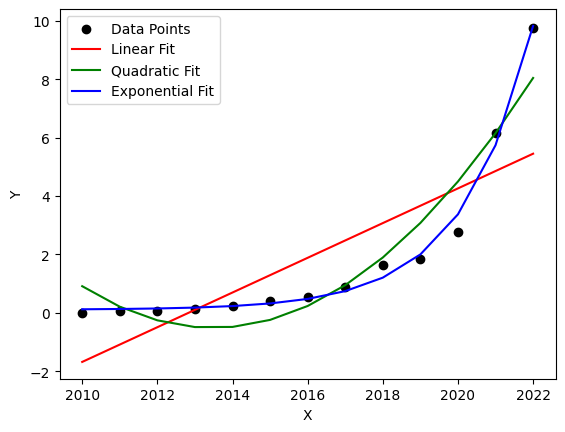

<function dict.get(key, default=None, /)>

In [21]:
# Define the dataset as arrays of X and Y values
#x_data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# Define the R-squared function
def r_squared(y, y_pred):
    residual = np.sum((y - y_pred) ** 2)
    total = np.sum((y - np.mean(y)) ** 2)
    r_sq = 1 - (residual / total)
    return r_sq

# Visualize the data and original points
plt.scatter(x_data, y_data, label='Data Points', color='black')
plt.xlabel('X')
plt.ylabel('Y')

# Fit a linear model to the data
def linear_func(x, a, b):
    return a * x + b

linear_params, _ = curve_fit(linear_func, x_data, y_data)
plt.plot(x_data, linear_func(x_data, *linear_params), 'r', label='Linear Fit')

# Fit a quadratic model to the data
def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

quadratic_guesses = [1, 1, 1]  # Initial guesses for the quadratic fit
quadratic_params, _ = curve_fit(quadratic_func, x_data, y_data, p0=quadratic_guesses)
plt.plot(x_data, quadratic_func(x_data, *quadratic_params), 'g', label='Quadratic Fit')

# Fit an exponential model to the data
def exponential_func(x, a, b, c):
    return a * np.exp(b * (x - 2010)) + c

exponential_guesses = [1, 1, 1]  # Initial guesses for the exponential fit
exponential_params, _ = curve_fit(exponential_func, x_data, y_data, p0=exponential_guesses)
plt.plot(x_data, exponential_func(x_data, *exponential_params), 'b', label='Exponential Fit')

# Print the best fit
r_squared_values = {
    'Linear': r_squared(y_data, linear_func(x_data, *linear_params)),
    'Quadratic': r_squared(y_data, quadratic_func(x_data, *quadratic_params)),
    'Exponential': r_squared(y_data, exponential_func(x_data, *exponential_params))
}

best_fit = max(r_squared_values, key=r_squared_values.get)
print("Best Fit: ", best_fit)

plt.legend()
plt.show()

#r_squared_values_df = pd.DataFrame(r_squared_values)
display(r_squared_values.get)

In [22]:
print("Quadratic guesses: ", quadratic_params)
print("Exponential guesses: ", exponential_params)

Quadratic guesses:  [ 1.17828903e-01 -4.74492125e+02  4.77689534e+05]
Exponential guesses:  [0.01396663 0.54538719 0.11010673]


In [23]:
# Define the R-squared function
def r_squared(y, y_pred):
    residual = np.sum((y - y_pred) ** 2)
    total = np.sum((y - np.mean(y)) ** 2)
    r_sq = 1 - (residual / total)
    return r_sq

# Fit a linear model to the data
def linear_func(x, a, b):
    return a * x + b

linear_params, _ = curve_fit(linear_func, x_data, y_data)

# Fit a quadratic model to the data
def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

quadratic_guesses = [1, 1, 1]  # Initial guesses for the quadratic fit
quadratic_params, _ = curve_fit(quadratic_func, x_data, y_data, p0=quadratic_guesses)

# Fit an exponential model to the data
def exponential_func(x, a, b, c):
    return a * np.exp(b * (x - 2010)) + c

exponential_guesses = [1, 1, 1]  # Initial guesses for the exponential fit
exponential_params, _ = curve_fit(exponential_func, x_data, y_data, p0=exponential_guesses)

# Calculate R-squared values
r_squared_values = {
    'Linear': r_squared(y_data, linear_func(x_data, *linear_params)),
    'Quadratic': r_squared(y_data, quadratic_func(x_data, *quadratic_params)),
    'Exponential': r_squared(y_data, exponential_func(x_data, *exponential_params))
}

# Create a DataFrame with R-squared values
r_square_values_df = pd.DataFrame.from_dict(r_squared_values, orient='index', columns=['R-squared'])

# Visualize the data and fits using Plotly
fig = go.Figure()

# Original data points
fig.add_trace(go.Scatter(x=x_data, y=y_data, mode='markers', name='Data Points'))

# Linear fit
linear_fit = linear_func(x_data, *linear_params)
fig.add_trace(go.Scatter(x=x_data, y=linear_fit, mode='lines', name='Linear Fit'))

# Quadratic fit
quadratic_fit = quadratic_func(x_data, *quadratic_params)
fig.add_trace(go.Scatter(x=x_data, y=quadratic_fit, mode='lines', name='Quadratic Fit'))

# Exponential fit
exponential_fit = exponential_func(x_data, *exponential_params)
fig.add_trace(go.Scatter(x=x_data, y=exponential_fit, mode='lines', name='Exponential Fit'))

fig.update_layout(
    title="Best Fit",
    xaxis_title="X",
    yaxis_title="Y"
)

display(r_square_values_df)
fig.show()


,R-squared
Linear,0.630410
Quadratic,0.903264
Exponential,0.992409


# 7 Question #5 - Finding the EV curve of adoption

In [183]:
# x and y values
x_values = world_df['year']
y_values = world_df['ev_sales_share'] / 100 #ev_sales_share_change

# define the system of equations
def equations(p):
    mu, sd = p
    return y_values - 0.5 * (1 + special.erf((x_values - mu) / (sd * np.sqrt(2))))

# initial guess for the mean and standard deviation
mu_init, sd_init = 2028, 2

# solve the system of equations
solution = least_squares(equations, (mu_init, sd_init))

mu, sd = solution.x

print('Mean (μ):', mu)
print('Standard Deviation (σ):', sd)


Mean (μ): 2028.224475363723
Standard Deviation (σ): 3.9674458084839337


In [184]:
# Create an instance of the normal distribution
rv = norm(loc=mu, scale=sd)

# Calculate the CDF for a specific value
x = 2025
cdf = 0.5

cdf_value = rv.cdf(x)
pdf_value = rv.pdf(x)
ppf_value = rv.ppf(cdf)

print("CDF:", cdf_value)
print("PDF:", pdf_value)
print("X:", ppf_value)

CDF: 0.20818548946544618
PDF: 0.07227125819663154
X: 2028.224475363723


This project we will analyze the increasing demand of EVs and who's leading it, figure out in which stage of adoption we are and try to estimate how long will it take for the all car transportation to become electric by finding the EV adoption curve.

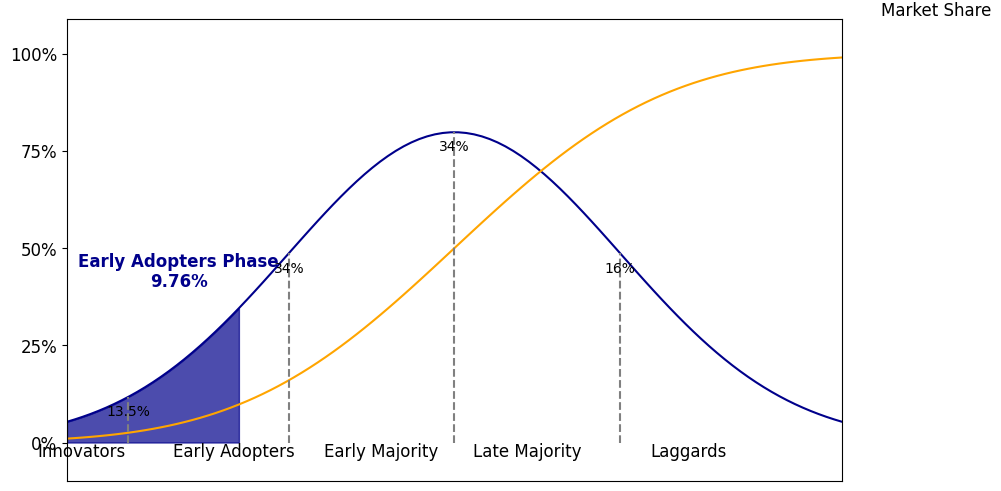

In [180]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set up your figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Define the mean and standard deviation
mu, sigma = 0, 0.5

# Generate the x values
x = np.linspace(norm.ppf(0.01, mu, sigma), norm.ppf(0.99, mu, sigma), 100)

# Plot the normal distribution
sns.lineplot(x=x, y=norm.pdf(x, mu, sigma), ax=ax1, color='darkblue')

# Plot the CDF
sns.lineplot(x=x, y=norm.cdf(x, mu, sigma), ax=ax1, color='orange')

# Shade the left tail up to 9.78%
x_fill = np.linspace(norm.ppf(0.01, mu, sigma), norm.ppf(0.0978, mu, sigma), 100)
ax1.fill_between(x_fill, 0, norm.pdf(x_fill, mu, sigma), alpha=0.7, color='darkblue')

# Define your adoption segments
segments = ['Innovators', 'Early Adopters', 'Early Majority', 'Late Majority', 'Laggards']
percentages = [2.5, 13.5, 34, 34, 16]

# Mark your adoption segments
for i, (segment, percentage) in enumerate(zip(segments, percentages)):
    if i > 0:  # Avoid going out of bounds on the list
        mid_point = (sum(percentages[:i]) + sum(percentages[:i+1])) / 2  # Mid point for label placement
    else:
        mid_point = percentage / 2

    x_loc_label = norm.ppf(mid_point/100, mu, sigma)  # x location for segment label
    x_loc_line = norm.ppf(sum(percentages[:i+1])/100, mu, sigma)  # x location for vertical line

    if np.isfinite(x_loc_label):  # check for valid location for label
        ax1.text(x_loc_label, 0, segment, 
                 horizontalalignment='center', verticalalignment='top', fontsize=12)

    if np.isfinite(x_loc_line) and i < len(percentages) - 1:  # check for valid location for vertical line
        ax1.vlines(x=x_loc_line, ymin=0, ymax=norm.pdf(x_loc_line, mu, sigma), color='grey', linestyle='--')  # Draw vertical line for segment division
        percentage_label_y = norm.pdf(x_loc_line, mu, sigma) - 0.02
        ax1.text(x_loc_line, percentage_label_y, f"{percentages[i+1]}%", 
                 horizontalalignment='center', verticalalignment='top', fontsize=10)

# Mark the shaded region
ax1.text(norm.ppf(0.0978/2, mu, sigma), norm.pdf(norm.ppf(0.13, mu, sigma), mu, sigma) + 0.03, 
         'Early Adopters Phase', horizontalalignment='center', color='darkblue', fontweight='bold', fontsize=12)
ax1.text(norm.ppf(0.0978/2, mu, sigma), norm.pdf(norm.ppf(0.12, mu, sigma), mu, sigma), 
         '9.76%', horizontalalignment='center', color='darkblue', fontweight='bold', fontsize=12)

# Remove x and y ticks
ax1.set_xticks([])
ax1.set_yticks([])

# Set y-axis label and position it on the right
ax1.set_ylabel('Market Share', fontsize=12, rotation='horizontal', ha='left')
ax1.yaxis.set_label_coords(1.05, 1)  # Adjust the position of the y-axis label

# Add y-axis ticks at 0, 25, 50, 75, and 100% marks
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax1.set_yticklabels(['0%', '25%', '50%', '75%', '100%'], fontsize=12)

# Add some margin below the x-axis
ax1.margins(x=0, y=0.1)

# Save the figure
plt.savefig('../resources/plots/current_phase_plot.png', dpi=300, bbox_inches='tight')

plt.show()


In [187]:

# Generate the x values with a wider range
x = np.linspace(mu - 3 * sd, mu + 3 * sd, 1000)

# Create the figure and axes
fig = go.Figure()

# Plot the normal distribution using a separate y-axis
fig.add_trace(go.Scatter(x=x, y=norm.pdf(x, mu, sd), mode='lines', name='PDF', line=dict(color='darkblue'), yaxis='y2'))

# Calculate the CDF using the same x values
cdf_y = norm.cdf(x, mu, sd)

# Plot the CDF
fig.add_trace(go.Scatter(x=x, y=cdf_y, mode='lines', name='CDF', line=dict(color='orange')))

# Shade the left tail up to 9.78%
x_fill = np.linspace(mu - 3 * sd, norm.ppf(0.0978, mu, sd), 100)
fig.add_trace(go.Scatter(x=x_fill, y=norm.pdf(x_fill, mu, sd), fill='tozeroy', fillcolor='#98FB98', opacity=0.1, name='Current PDF', yaxis='y2'))

# Customize the layout
fig.update_layout(
    xaxis=dict(showgrid=True, zeroline=False, dtick=1),  # Show gridlines, zeroline, and set dtick to 1 for 1 unit interval in x-axis
    yaxis=dict(showgrid=False, zeroline=True, range=[0, 1], ticktext=['0%', '25%', '50%', '75%', '100%'], tickvals=[0, 0.25, 0.5, 0.75, 1]),
    yaxis2=dict(showgrid=True, zeroline=False, overlaying='y', side='right', showticklabels=False, range=[0, 0.195]),  # Create a secondary y-axis without tick labels
    showlegend=True,
    margin=dict(l=2, r=2, t=2, b=20)
)

# Display the figure
fig.show()


# Charts

## Electric vs. Cobustion Sales

In [29]:
# Create a function to plot a stacked bar chart of Electric vs. Combustion sales
def create_stacked_bar_chart(df: pd.DataFrame):
    '''
    '''
    # Filter & rename dataframe
    world_df = df[df['region'] == 'World'].rename(columns={'ev_sales': 'Electric', 'ice_sales': 'Combustion'})
    
    # Create the stacked bar chart
    fig = px.bar(world_df, x='year', y=['Electric', 'Combustion'], title='Global Car Sales',
                color_discrete_sequence=['#90EE90', '#ADD8E6'])
    
    # Update the layout
    fig.update_layout(
        barmode='stack',
        legend=dict(
            orientation='h',
            yanchor='top',
            y=-0.2,
            xanchor='center',
            x=0.5
        ),
        xaxis_title=None,
        yaxis_title='Sales',
        xaxis={'type': 'category'})

    return fig

# Use the function to get the fig
fig = create_stacked_bar_chart(df)

# Display the chart
fig.show()

## World Sales Share with Trendline

In [98]:
def plot_world_sales_share(df: pd.DataFrame):
    '''
    '''
    world_df = df[df['region'] == 'World']
    
    def exponential_func(x, a, b, c):
        return a * np.exp(b * (x - 2010)) + c
    
    # World EV Sales
    fig = px.bar(world_df, x='year', y='ev_sales_share', title='World EV Sales')
    
    fig.update_layout(
        xaxis_title='',
        yaxis_title='World car sales share (%)',
        xaxis={'type': 'category'},
        showlegend=False
    )
    
    # Add exponential line
    x_values = world_df['year']
    a, b, c = 0.01396663, 0.54538719, 0.11010673
    y_exp = exponential_func(x_values, a, b, c)
    
    fig.add_trace(go.Scatter(x=x_values, y=y_exp, mode='lines', name='Exponential Fit'))
    
    fig.show()

plot_world_sales_share(df)

## Sales Share Trend Line by region

In [47]:
# Create function
def create_plot_and_fit(df: pd.DataFrame) -> tuple:
    '''
    '''

    # Assign x and y data
    x_data = df['year']
    y_data = df['ev_sales_share']
    
    # Define the R-squared function
    def r_squared(y, y_pred):
        residual = np.sum((y - y_pred) ** 2)
        total = np.sum((y - np.mean(y)) ** 2)
        r_sq = 1 - (residual / total)
        return r_sq
    
    # Fit a linear model to the data
    def linear_func(x, a, b):
        return a * x + b
    
    linear_params, _ = curve_fit(linear_func, x_data, y_data)
    
    # Fit a quadratic model to the data
    def quadratic_func(x, a, b, c):
        return a * x**2 + b * x + c
    
    quadratic_guesses = [1, 1, 1]  # Initial guesses for the quadratic fit
    quadratic_params, _ = curve_fit(quadratic_func, x_data, y_data, p0=quadratic_guesses)
    
    # Fit an exponential model to the data
    def exponential_func(x, a, b, c):
        return a * np.exp(b * (x - 2010)) + c
    
    exponential_guesses = [1, 1, 1]  # Initial guesses for the exponential fit
    exponential_params, _ = curve_fit(exponential_func, x_data, y_data, p0=exponential_guesses)
    
    # Calculate R-squared values
    r_squared_values = {
        'Linear': r_squared(y_data, linear_func(x_data, *linear_params)),
        'Quadratic': r_squared(y_data, quadratic_func(x_data, *quadratic_params)),
        'Exponential': r_squared(y_data, exponential_func(x_data, *exponential_params))
    }
    
    # Create a DataFrame with R-squared values
    r_squared_values_df = pd.DataFrame.from_dict(r_squared_values, orient='index', columns=['R-squared'])
    
    # Visualize the data and fits using Plotly
    fig = go.Figure()
    
    # Original data points
    fig.add_trace(go.Bar(x=x_data, y=y_data, name='Electric', marker_color='#90EE90'))
    
    # Linear fit
    linear_fit = linear_func(x_data, *linear_params)
    fig.add_trace(go.Scatter(x=x_data, y=linear_fit, mode='lines', name='Linear Fit', line=dict(color='#f39c12', dash='dashdot')))
    
    # Quadratic fit
    quadratic_fit = quadratic_func(x_data, *quadratic_params)
    fig.add_trace(go.Scatter(x=x_data, y=quadratic_fit, mode='lines', name='Quadratic Fit', line=dict(color='#27ae60', dash='dash')))
    
    # Exponential fit
    exponential_fit = exponential_func(x_data, *exponential_params)
    fig.add_trace(go.Scatter(x=x_data, y=exponential_fit, mode='lines', name='Exponential Fit', line=dict(color='#e74c3c', width=3)))
    
    fig.update_layout(
        title="Car Sales Share",
        xaxis_title="",
        yaxis_title="Sales Share (%)",
        xaxis={'type': 'category'}
    )

    return fig, r_squared_values_df


df1 = df[df['region'] == 'China']

fig , r_squared_values_df = create_plot_and_fit(df1)

display(r_squared_values_df)
fig.show()

,R-squared
Linear,0.602054
Quadratic,0.878371
Exponential,0.983669


## Sales Leader by Country

In [64]:
# List regions that are not countries to filter them out
exclude_regions = ['World','Europe','EU27','Other Europe','Rest of the world']

# Filter df to get rank of countries
sales_country_rank = df[(df['year']==2022) & (~df['region'].isin(exclude_regions))][['region','ev_sales','ev_sales_share']].sort_values('ev_sales_share', ascending = False)

# Create rank column
sales_country_rank['ev_sales_rank'] = sales_country_rank.reset_index().index + 1

# Get EV global sales for 2022
current_world_sales = df[df['region'] == 'World']['ev_sales'].tail(1).iloc[0]

# Create calculated column with share of ev cars sold over total ev sales by country
sales_country_rank['ev_sales_country_share'] = ((sales_country_rank['ev_sales'] / current_world_sales) * 100).round(1)

# Show top 10 countries
sales_country_rank = sales_country_rank[['ev_sales_rank', 'region', 'ev_sales_country_share', 'ev_sales']].head(10)
sales_country_rank.style.hide(axis="index")

ev_sales_rank,region,ev_sales_country_share,ev_sales
1,China,60.300000,4400000
2,USA,11.000000,800000
3,Germany,6.400000,470000
4,United Kingdom,3.700000,270000
5,France,2.900000,210000
6,Norway,2.100000,150000
7,Korea,1.600000,120000
8,Sweden,1.300000,96000
9,Canada,1.200000,85000
10,Netherlands,1.000000,73000
